In [1]:
import pandas as pd
import numpy as np
import csv
import pickle
import seaborn as sns
import numpy as np
from scipy.optimize import curve_fit
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
Path='/home/mgander/Atlantic/data/Viability/'
M = pd.read_pickle(f'{Path}/M_all_all.pkl')
M = M[M.Source!='PRISM1'].copy()
M['log_dose']=np.log10(M['Dose'])
M['key']=M['Cello']+'_'+M['PubChem_CID']
M['log_dose_rounded']= (M['log_dose']*10).astype('int')
sources = sorted(set(M['Source']))
sources

['CTD2', 'CTPR', 'DTP', 'GDSC1', 'GDSC2', 'MR_NCI60', 'PRISM2']

In [3]:
def add_ccl_and_drugs_annot(df):
    df['Cello']=[a.split('_')[0] for a in df.index]
    df['PubChem_CID']=[a.split('_')[1] for a in df.index]
    df['pEC50'] = - df['-pec50']
    del df['-pec50']
    return(df)
def get_intervals(dfg):
    # rounded dose onto 1 decimal
    lefts = [a[1]['log_dose_rounded'].min() for a in list(dfg.groupby('Cello'))]
    rights = [a[1]['log_dose_rounded'].max() for a in list(dfg.groupby('Cello'))]

    left_maj = list(pd.DataFrame(lefts, columns=['v']).value_counts().index)[0][0]
    right_maj = list(pd.DataFrame(rights, columns=['v']).value_counts().index)[0][0]
    return(left_maj, right_maj)

In [4]:
# These are the results from the fitting
F={}
F['CTD2'] = add_ccl_and_drugs_annot(pd.read_pickle(f'{Path}/dff_ctd2.pkl'))
F['CTPR'] = add_ccl_and_drugs_annot(pd.read_pickle(f'{Path}/dff_ctrp.pkl'))
F['DTP'] = add_ccl_and_drugs_annot(pd.read_pickle(f'{Path}/dff_dtp.pkl'))
F['GDSC1'] = add_ccl_and_drugs_annot(pd.read_pickle(f'{Path}/dff_gdsc1.pkl'))
F['GDSC2'] = add_ccl_and_drugs_annot(pd.read_pickle(f'{Path}/dff_gdsc2.pkl'))
F['MR_NCI60'] = add_ccl_and_drugs_annot(pd.read_pickle(f'{Path}/dff_inhouse.pkl'))
F['PRISM2'] = add_ccl_and_drugs_annot(pd.read_pickle(f'{Path}/dff_prism.pkl'))

In [6]:
i=1
source = sources[i]
Fs=F[source]
Ms=M[M['Source']==source].copy()

In [7]:
drugs = sorted(set(Fs['PubChem_CID']))

In [8]:
j=10
#for dr in drugs:
dr=drugs[j]
dr

'11228183'

In [10]:
Ms[Ms['PubChem_CID']=='11228183']

,CCL,Drug,Dose,Duration,Viability,Source,CCL_reduced,Cello,PubChem_CID,Dr_repr_name,log_dose,key,log_dose_rounded
12478222,5637,ABT-737,0.2890,72.0,0.96,CTPR,5637,5637,11228183,ABT737,-0.539102,5637_11228183,-5
12478223,5637,ABT-737,0.5780,72.0,0.92,CTPR,5637,5637,11228183,ABT737,-0.238072,5637_11228183,-2
12478224,5637,ABT-737,1.1563,72.0,0.94,CTPR,5637,5637,11228183,ABT737,0.063071,5637_11228183,0
12478225,5637,ABT-737,2.3123,72.0,0.88,CTPR,5637,5637,11228183,ABT737,0.364044,5637_11228183,3
12478226,5637,ABT-737,4.6250,72.0,0.85,CTPR,5637,5637,11228183,ABT737,0.665112,5637_11228183,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12480265,WSUDLCL2,ABT-737,2.3125,72.0,0.75,CTPR,WSUDLCL2,WSUDLCL2,11228183,ABT737,0.364082,WSUDLCL2_11228183,3
12480266,WSUDLCL2,ABT-737,4.6250,72.0,0.23,CTPR,WSUDLCL2,WSUDLCL2,11228183,ABT737,0.665112,WSUDLCL2_11228183,6
12480267,WSUDLCL2,ABT-737,9.2500,72.0,0.21,CTPR,WSUDLCL2,WSUDLCL2,11228183,ABT737,0.966142,WSUDLCL2_11228183,9
12480268,WSUDLCL2,ABT-737,18.5000,72.0,0.00,CTPR,WSUDLCL2,WSUDLCL2,11228183,ABT737,1.267172,WSUDLCL2_11228183,12


In [386]:
Mss = Ms[Ms['PubChem_CID']==dr].copy()

In [387]:
def get_sensitivities_for_Mss(Mss, Fs, cut0=0.3, cut1=0.6):
    Dm={}
    
    keys = sorted(set(Mss['key']))
    pec50s = Fs.loc[keys]['pEC50']
    x0,x1=np.array(get_intervals(Mss))/10
    pec50s[pec50s>x1]=x1
    pec50s[pec50s<x0]=x0
    
    med = np.median(pec50s)
    cutoff0 = med-cut0
    cutoff1 = med-cut1
    
    inds=list(pec50s.index)
    vals=list(pec50s.values)
    for i in range(len(inds)):
        v=vals[i]
        if v>cutoff0:
            Dm[inds[i]]='not'
        elif v>cutoff1:
            Dm[inds[i]]='maybe'
        else:
            Dm[inds[i]]='yes'
    return(Dm, pec50s)

In [388]:
Dm, pec50s = get_sensitivities_for_Mss(Mss, Fs)

In [389]:
dfpec50 = pd.DataFrame(pec50s)
dfpec50['sensitive']=dfpec50.index.map(Dm)

<Axes: xlabel='pEC50', ylabel='Count'>

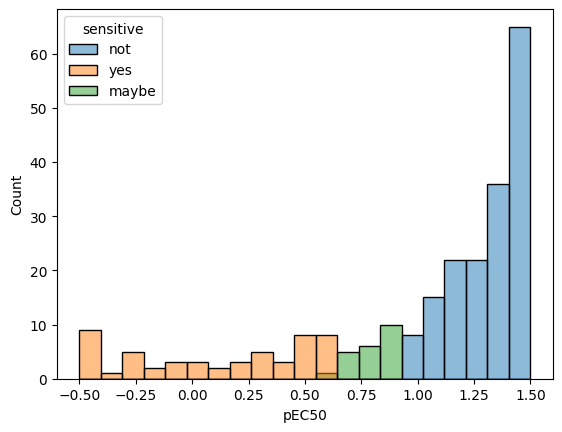

In [390]:
sns.histplot(data=dfpec50, x='pEC50', hue='sensitive', bins=21)

In [393]:
Mss['sensitive'] = Mss['key'].map(Dm)

<Axes: xlabel='log_dose', ylabel='Viability'>

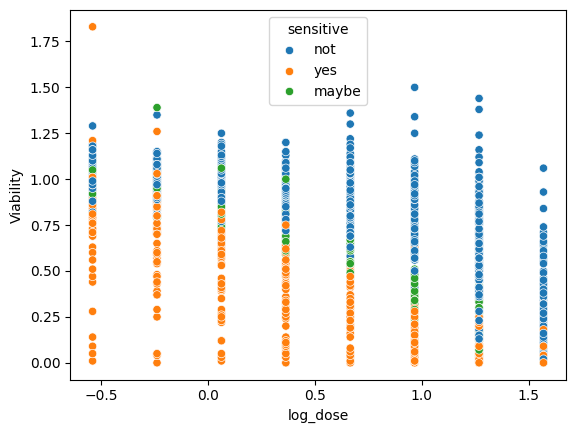

In [395]:
sns.scatterplot(data=Mss, x='log_dose', y='Viability', hue='sensitive')

In [396]:
# some random curves

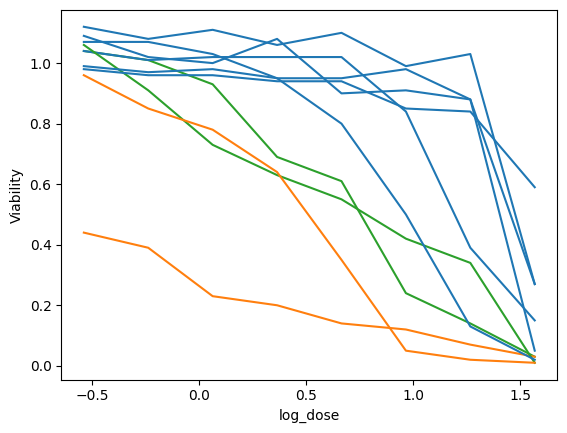

In [414]:
ccls = np.random.choice(sorted(set(Mss['Cello'])), 10)
Msss = Mss[Mss['Cello'].isin(ccls)].copy()
pal = sns.color_palette()
Dcolor={'not':pal[0], 'maybe':pal[2], 'yes':pal[1]}
for ccl in ccls:
    Mssss = Msss[Msss['Cello']==ccl]
    s = Mssss['sensitive'].iloc[0]
    sns.lineplot(data=Msss[Msss['Cello']==ccl], x='log_dose', y='Viability', c=Dcolor[s])